<a href="https://colab.research.google.com/github/karammasad/DetectBot/blob/main/MotorDown%20(Baker%20Hughes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



# Dataset #1 & #2

In [ ]:
import pandas as pd

# Load the data
data = pd.read_csv("/content/gdrive/MyDrive/Challenge Info/data_set_2.csv", header = None)

# Rename columns for clarity
data.columns = ['Index', 'X1_Frequency', 'X2_Power']



# Maintaining Original Distribution

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 'data' is the DataFrame, 'X1_Frequency' and 'X2_Power' columns

# Step 1: Grid bins for X1_Frequency and X2_Power.
n_bins = 50  # Number of bins along each axis
data['Bin_X1'] = pd.cut(data['X1_Frequency'], bins=n_bins, labels=False)
data['Bin_X2'] = pd.cut(data['X2_Power'], bins=n_bins, labels=False)

# Step 2: Determine density by calculating the number of points in each bin.
bin_counts = data.groupby(['Bin_X1', 'Bin_X2']).size().reset_index(name='Count')

# Step 3: Identify the propoertion of point per bin.
total_points = len(data)
bin_counts['Density_Proportion'] = bin_counts['Count'] / total_points

# Step 4: Allocate points to each bin based on density proportion
bin_counts['Points_To_Select'] = (bin_counts['Density_Proportion'] * 2500).round().astype(int)
points_to_add = 2500 - bin_counts['Points_To_Select'].sum()

# Step 5: Adjust allocation to ensure exactly 2500 points. If we're off, we add or remove points from bins to reach exactly 2500.
if points_to_add > 0: # Add points to the bins

    indices_to_add = bin_counts.nlargest(points_to_add, 'Density_Proportion').index
    bin_counts.loc[indices_to_add, 'Points_To_Select'] += 1
elif points_to_add < 0: # Remove points from the least dense bins
    indices_to_remove = bin_counts.nsmallest(-points_to_add, 'Density_Proportion').index
    bin_counts.loc[indices_to_remove, 'Points_To_Select'] -= 1

# Step 6: Make sure the selected points are integers.
print(bin_counts['Points_To_Select'].dtype)

# Step 7: Sample points from each bin based on calculated allocation.
selected_indices = []

for _, row in bin_counts.iterrows():
    bin_x1, bin_x2 = row['Bin_X1'], row['Bin_X2']
    points_in_bin = data[(data['Bin_X1'] == bin_x1) & (data['Bin_X2'] == bin_x2)]
    n_points_to_select = int(row['Points_To_Select'])
    if n_points_to_select > 0:
        selected_points = points_in_bin.sample(n=n_points_to_select, random_state=42).index.tolist()
        selected_indices.extend(selected_points)

# Step 8: Compile the selected points into DataFrame (exactly 2500 points).
selected_data = data.loc[selected_indices]

# Step 9: Display the selected points with their index values.
print(selected_data.head())
print(f"Total selected points: {len(selected_data)}")


int64
         Index  X1_Frequency  X2_Power  Bin_X1  Bin_X2
170703  170704      0.390914  0.071193       0       0
239611  239612      0.393349  0.074674       0       1
383786  383787      0.392264  0.079540       0       1
433736  433737      0.392304  0.078643       0       1
170872  170873      0.391648  0.074816       0       1
Total selected points: 2500


# Plotting Density Curves to Display Equal Distributions

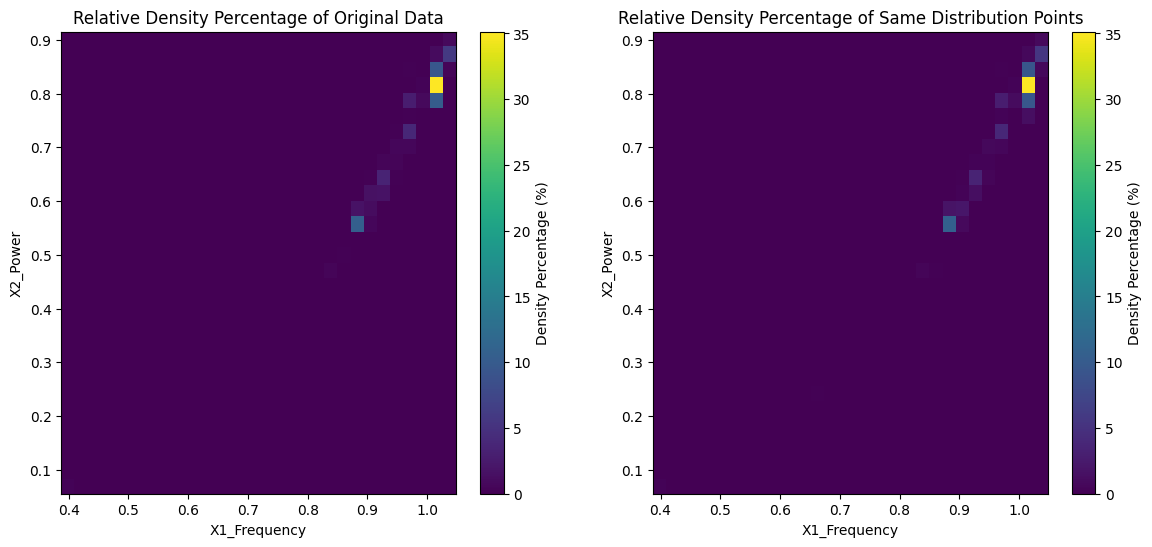

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Computing the releative density percentages for the dataset.
def compute_relative_density_percentage(data, bins=30):
    x = data['X1_Frequency']
    y = data['X2_Power']
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
    hist_percentage = hist / hist.sum() * 100  # Relative density is a percentage.
    return hist_percentage, xedges, yedges

# Step 2: Comparing relative density percentages for orginal dataset and selected dataset.
hist_data_percent, xedges, yedges = compute_relative_density_percentage(data)
hist_selected_percent, _, _ = compute_relative_density_percentage(selected_data)

# Step 3: Find the maximum density percentage across both histograms.
vmax = min(hist_data_percent.max(), hist_selected_percent.max())

# Step 4: Plot the relative density of the original data.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
cax1 = ax[0].imshow(hist_data_percent.T, origin='lower', aspect='auto',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis', vmin=0, vmax=vmax)
ax[0].set_title('Relative Density Percentage of Original Data')
ax[0].set_xlabel('X1_Frequency')
ax[0].set_ylabel('X2_Power')
fig.colorbar(cax1, ax=ax[0], label='Density Percentage (%)')

# Step 5: Plot the relative density of the selected points.
cax2 = ax[1].imshow(hist_selected_percent.T, origin='lower', aspect='auto',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis', vmin=0, vmax=vmax)
ax[1].set_title('Relative Density Percentage of Same Distribution Points')
ax[1].set_xlabel('X1_Frequency')
ax[1].set_ylabel('X2_Power')
fig.colorbar(cax2, ax=ax[1], label='Density Percentage (%)')

plt.show()


# Plotting Original Data Normalized Along with 2500 Point Dataset to Show Equivalence.


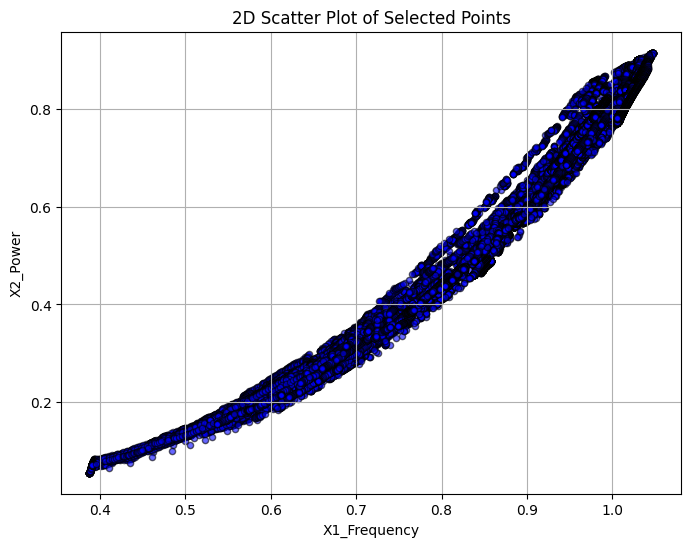

In [ ]:
#2D Scatter Plot of the selected points.
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data['X1_Frequency'], data['X2_Power'], alpha=0.6, c='blue', edgecolor='k', s=20)
plt.xlabel('X1_Frequency')
plt.ylabel('X2_Power')
plt.title('2D Scatter Plot of Selected Points')
plt.grid(True)
plt.show()

#Visualizing Normalized 3D Histogram of Data Distribution

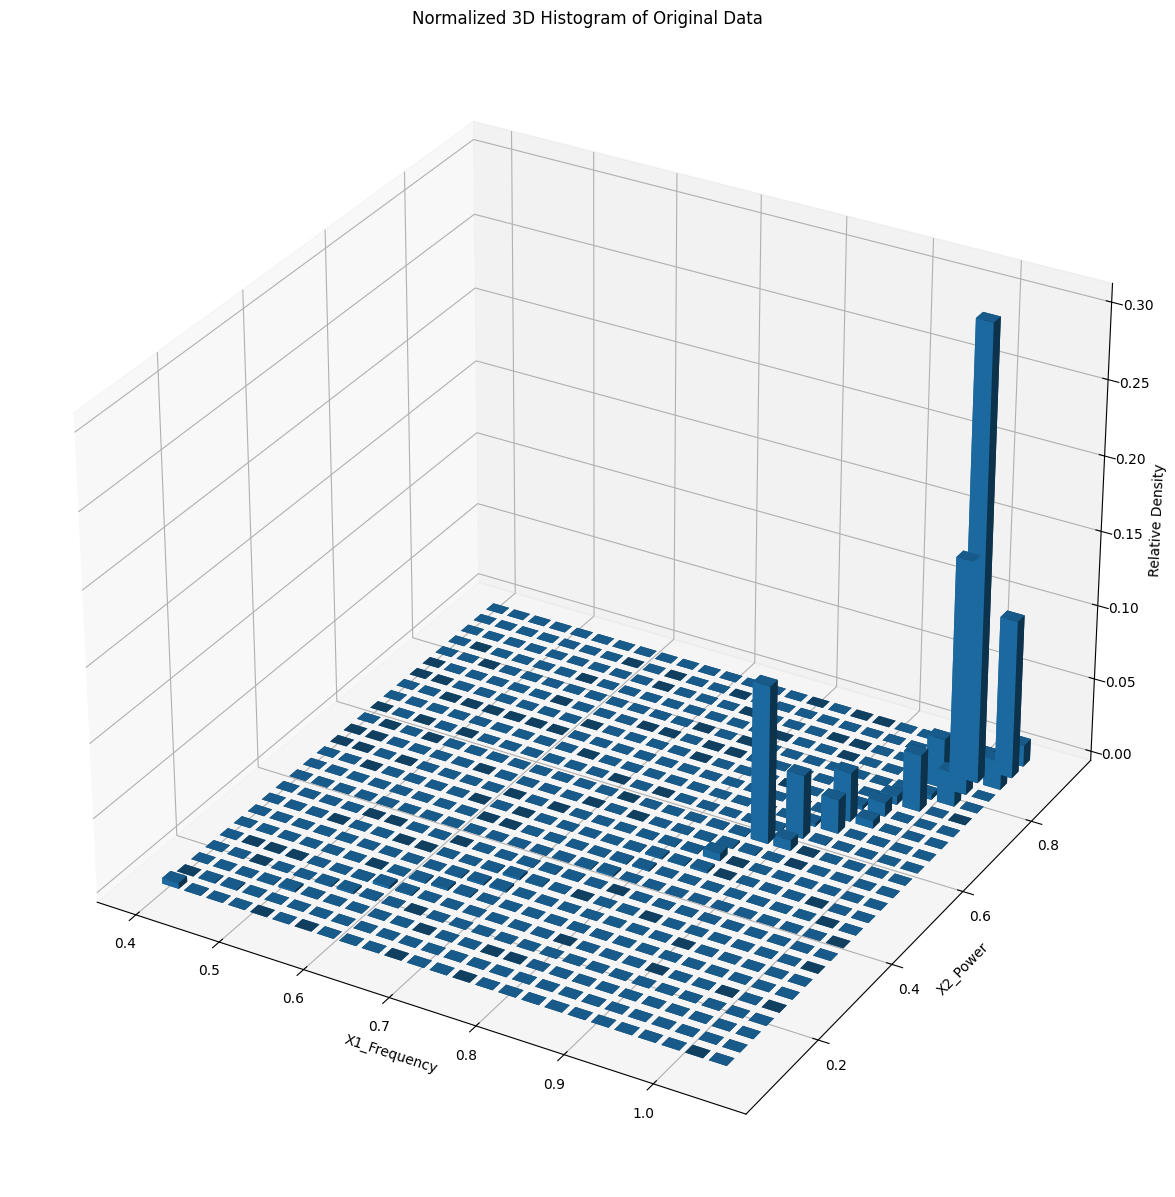

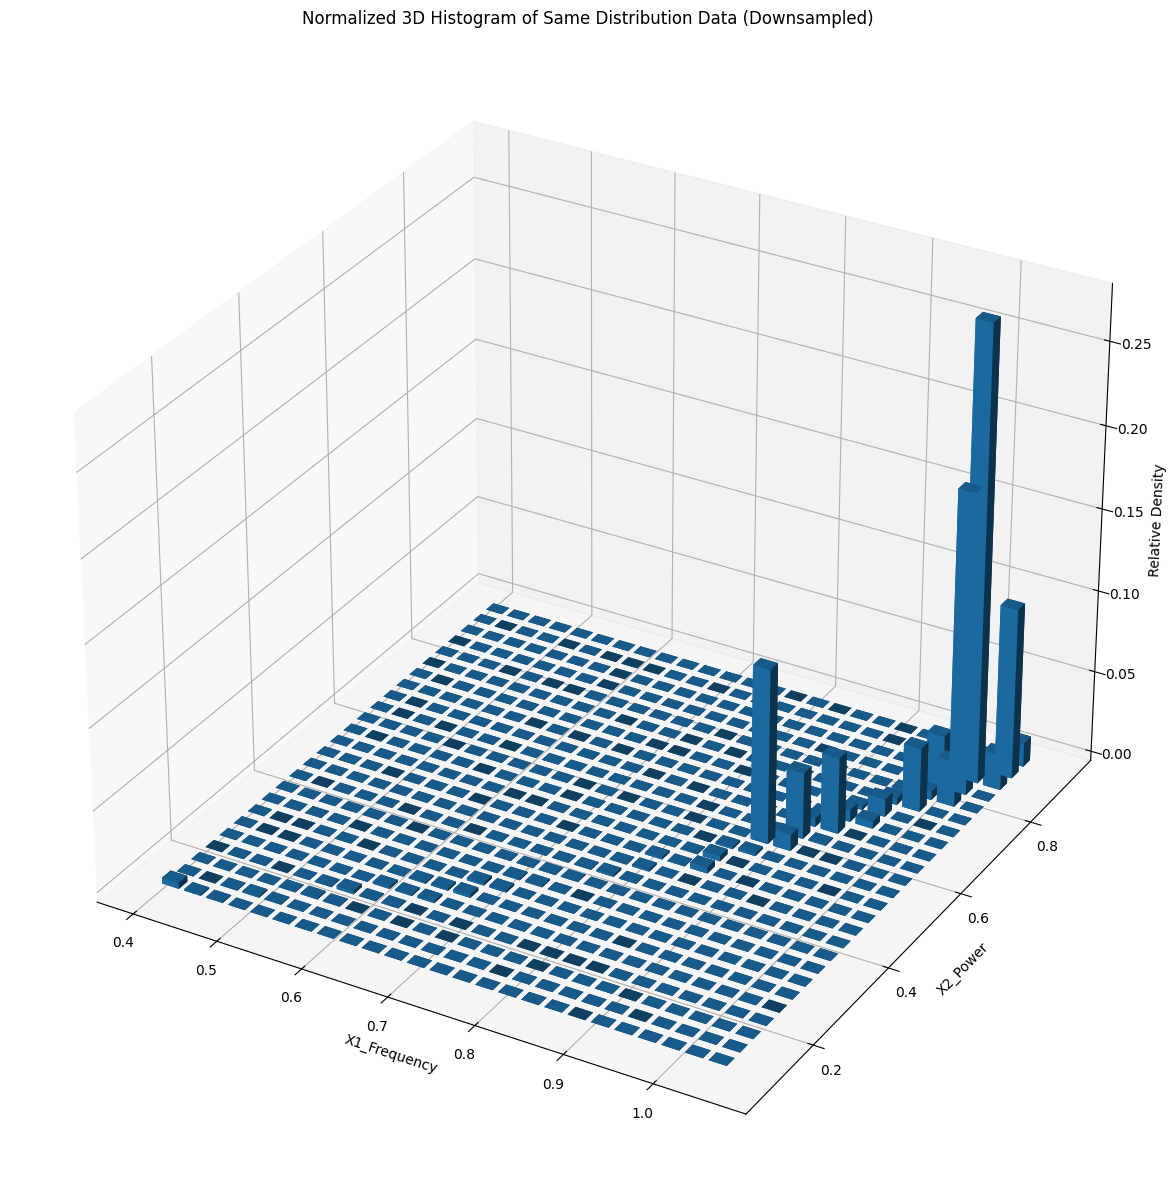

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Step 1: Defined functions to plot a normalized 3D histogram the dataset
def plot_normalized_3d_histogram(data, title, bins=25, zlim=None):
    x = data['X1_Frequency']
    y = data['X2_Power']

# Step 2: Calculation for 2D histogram for density calculation
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
    hist = hist / hist.sum()

# Step 3: Arrays for the 3D bar plot
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.5 * (xedges[1:] - xedges[:-1]),
                             yedges[:-1] + 0.5 * (yedges[1:] - yedges[:-1]), indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

# Step 4: Plot the normalized 2D histogram
    dz = hist.ravel()

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    ax.bar3d(xpos, ypos, zpos, 0.02, 0.02, dz, zsort='average')

    ax.set_xlabel('X1_Frequency')
    ax.set_ylabel('X2_Power')
    ax.set_zlabel('Relative Density')
    ax.set_title(title)

    if zlim:
        ax.set_zlim(0, zlim)

    plt.show()

# Step 5: Plot the normalized 3D histogram for the original data
plot_normalized_3d_histogram(data, "Normalized 3D Histogram of Original Data", bins=25)

# Step 6: Plot the normalized 3D histogram for the selected data points
plot_normalized_3d_histogram(selected_data, "Normalized 3D Histogram of Same Distribution Data (Downsampled)", bins=25)


## Compute 2D Histograms for Original and Selected Datasets


In [ ]:
# Compute 2D histograms for both datasets
hist_data, xedges, yedges = np.histogram2d(data['X1_Frequency'], data['X2_Power'], bins=30)
hist_selected, _, _ = np.histogram2d(selected_data['X1_Frequency'], selected_data['X2_Power'], bins=30)


In [ ]:
# Ensure that selected_data has 'Index' as its index

# Select only 'Index', 'X1_Frequency', and 'X2_Power' columns
selected_data_csv = selected_data[['Index', 'X1_Frequency', 'X2_Power']]
# Save the selected data to a CSV file
selected_data_csv.to_csv('selected_data.csv', index=False)

from google.colab import files
files.download('selected_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Statistical Comparison of Histograms Using Similarity Metrics

In [ ]:
import numpy as np
from scipy.spatial import distance
from scipy.stats import wasserstein_distance
from sklearn.metrics import mean_squared_error

# Step 1: Normalize histograms to probabilities
hist_data_flat = hist_data.ravel() / hist_data.sum()
hist_selected_flat = hist_selected.ravel() / hist_selected.sum()

# (1) Mean Squared Error (MSE)
mse_value = mean_squared_error(hist_data_flat, hist_selected_flat)
print(f"Mean Squared Error (MSE): {mse_value}")

# (2) Jensen-Shannon Divergence (JSD)
jsd_value = distance.jensenshannon(hist_data_flat, hist_selected_flat)
print(f"Jensen-Shannon Divergence (JSD): {jsd_value}")

# (3) Earth Mover’s Distance (EMD) / Wasserstein Distance
emd_value = wasserstein_distance(hist_data_flat, hist_selected_flat)
print(f"Earth Mover's Distance (Wasserstein Distance): {emd_value}")


Mean Squared Error (MSE): 5.641685688888889e-07
Jensen-Shannon Divergence (JSD): 0.10992026926215928
Earth Mover's Distance (Wasserstein Distance): 5.283555555555553e-05


# Uniform Sampling and Coefficient of Variation (CV) Optimization for Dataset Distribution


In [ ]:
import numpy as np
import pandas as pd

#What are we looking for?
#1. Creates uniform samples for different numbers of top bins.
#2. Ensures that the total number of points sampled is exactly target_size (2,500).
#3. Keeps the uniform_data with the lowest CV as the best sample.


def create_uniform_sample(data, n_bins=50, target_size=2500, top_bins_list=[150, 200, 250, 300, 350, 400, 450, 500, 550, 600]):

    # Define bin edges for both features
    x1_min, x1_max = data['X1_Frequency'].min(), data['X1_Frequency'].max()
    x2_min, x2_max = data['X2_Power'].min(), data['X2_Power'].max()
    x1_bins = np.linspace(x1_min, x1_max, n_bins + 1)
    x2_bins = np.linspace(x2_min, x2_max, n_bins + 1)

    # Assign each point to a bin
    data['X1_bin'] = np.digitize(data['X1_Frequency'], x1_bins) - 1
    data['X2_bin'] = np.digitize(data['X2_Power'], x2_bins) - 1

    # Calculate counts in each bin
    bin_counts = data.groupby(['X1_bin', 'X2_bin']).size().reset_index(name='count')

    # Sort bins by count (density)
    bin_counts = bin_counts.sort_values(by='count', ascending=False).reset_index(drop=True)

    # Initialize variables to keep track of the best sample
    best_cv = float('inf')
    best_uniform_data = None
    best_top_bins = None

    # For each number of top bins to try
    for top_bins in top_bins_list:
        # Adjust top_bins if necessary
        actual_top_bins = min(top_bins, len(bin_counts))
        if actual_top_bins == 0:
            print(f"No bins available for top_bins = {top_bins}. Skipping.")
            continue

        # Select the top bins
        top_bin_indices = bin_counts.head(actual_top_bins)[['X1_bin', 'X2_bin']]

        # Calculate points per bin and remaining points
        points_per_bin = target_size // actual_top_bins
        remaining_points = target_size % actual_top_bins

        # Initialize a list to hold sampled data and sample sizes per bin
        sampled_data = []
        bin_sample_sizes = []

        # For each bin, sample points_per_bin data points
        for idx in range(actual_top_bins):
            x1_bin, x2_bin = top_bin_indices.iloc[idx]
            bin_data = data[(data['X1_bin'] == x1_bin) & (data['X2_bin'] == x2_bin)]

            sample_size = points_per_bin
            bin_sample_sizes.append(sample_size)

            # If there are fewer points in bin than sample_size, sample with replacement
            if len(bin_data) >= sample_size:
                sampled_bin_data = bin_data.sample(n=sample_size, random_state=42)
            else:
                sampled_bin_data = bin_data.sample(n=sample_size, replace=True, random_state=42)
            sampled_data.append(sampled_bin_data)

        # Distribute remaining points in a round-robin fashion
        idx = 0
        while remaining_points > 0:
            idx_in_bins = idx % actual_top_bins
            x1_bin, x2_bin = top_bin_indices.iloc[idx_in_bins]
            bin_data = data[(data['X1_bin'] == x1_bin) & (data['X2_bin'] == x2_bin)]
            already_sampled_indices = sampled_data[idx_in_bins].index
            available_bin_data = bin_data.drop(index=already_sampled_indices, errors='ignore')

            # Check if there is available data to sample
            if len(available_bin_data) >= 1:
                additional_sample = available_bin_data.sample(n=1, random_state=42)
            else:
                # If no available data, sample with replacement
                additional_sample = bin_data.sample(n=1, random_state=42, replace=True)

            # Append the additional sample
            sampled_data[idx_in_bins] = pd.concat([sampled_data[idx_in_bins], additional_sample])
            bin_sample_sizes[idx_in_bins] += 1  # Update the sample size for this bin
            remaining_points -= 1
            idx += 1

        # Concatenate all sampled data
        current_uniform_data = pd.concat(sampled_data).reset_index(drop=True)

        # Verify that the total number of points is exactly target_size
        total_sampled_points = len(current_uniform_data)
        if total_sampled_points != target_size:
            print(f"Error: Total sampled points ({total_sampled_points}) does not equal target size ({target_size}) for top_bins = {top_bins}.")
            continue

        # Drop the bin columns to clean up the dataframe
        current_uniform_data = current_uniform_data.drop(columns=['X1_bin', 'X2_bin'], errors='ignore')

        # Measure the uniformity (CV)
        cv = measure_uniformity(current_uniform_data, n_bins=25)
        print(f"Top bins: {top_bins}, Coefficient of Variation (CV): {cv:.4f}")
        # Print sample sizes per bin for verification
        print(f"Sample sizes per bin: {bin_sample_sizes}")

        # Check if this is the best (lowest CV) so far
        if cv < best_cv:
            best_cv = cv
            best_uniform_data = current_uniform_data
            best_top_bins = top_bins

    # After the loop, best_uniform_data contains the data with the lowest CV
    if best_uniform_data is not None:
        print(f"\nBest uniform data obtained with top_bins = {best_top_bins}, CV = {best_cv:.4f}")
        # Save the best uniform data to a CSV file
        best_uniform_data.to_csv('uniform_sample_best.csv', index=False)
    else:
        print("Unable to create uniform sample with the given parameters.")

    # Clean up the 'X1_bin' and 'X2_bin' columns from the original data
    data.drop(columns=['X1_bin', 'X2_bin'], inplace=True, errors='ignore')

    return best_uniform_data

def measure_uniformity(uniform_data, n_bins=25):

#What are we measuring?
#1. Measures the uniformity of a dataset by calculating the coefficient of variation (CV) of bin counts.
#2. Lower CV indicates a more uniform distribution.

    hist, _, _ = np.histogram2d(uniform_data['X1_Frequency'], uniform_data['X2_Power'], bins=n_bins)
    hist_flat = hist.ravel()
    mean_count = np.mean(hist_flat)
    std_dev = np.std(hist_flat)
    cv = std_dev / mean_count if mean_count != 0 else float('inf')  # Coefficient of Variation
    return cv

# 'data' dataframe with 500,000 data points
top_bins_list = [150, 200, 250, 300, 350, 400, 450, 500, 550, 600]  # You can adjust this list as needed
uniform_data = create_uniform_sample(data, n_bins=50, target_size=2500, top_bins_list=top_bins_list)



Top bins: 150, Coefficient of Variation (CV): 3.3185
Sample sizes per bin: [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
Top bins: 200, Coefficient of Variation (CV): 2.9652
Sample sizes per bin: [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 

## 3D Histogram Visualization and Uniformity Analysis of Uniform Data


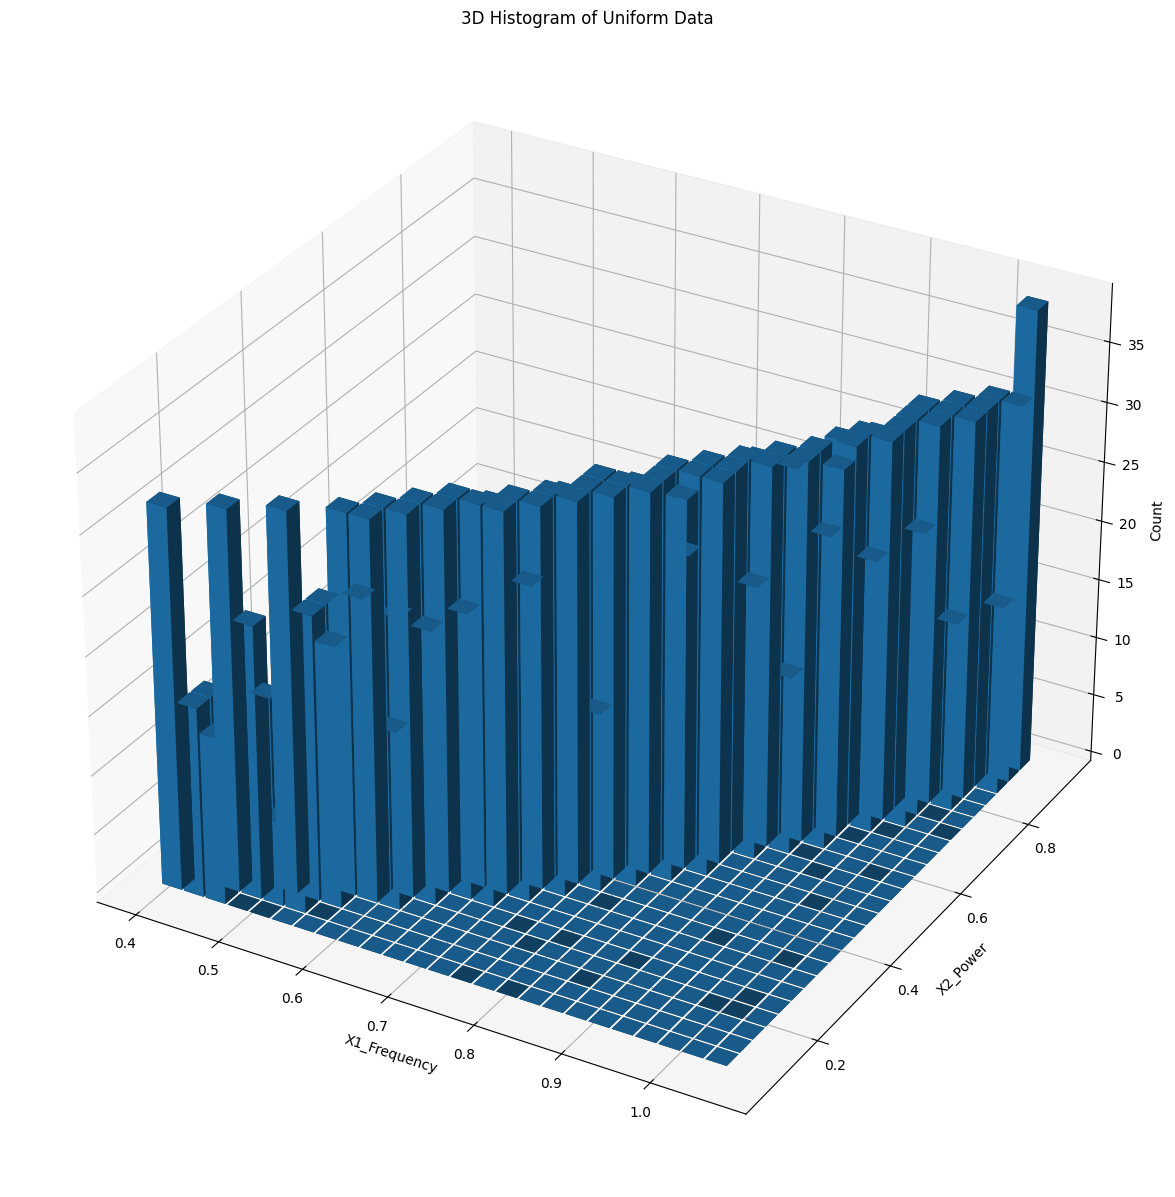

2.6352988445335757

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 'uniform_data' is the DataFrame, 'X1_Frequency' and 'X2_Power' columns

# Step 1: Define the number of bins for the histogram
n_bins = 25

# Step 2: Create the 3D histogram plot
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

#Step 3: Calculate the 2D histogram data
hist, xedges, yedges = np.histogram2d(uniform_data['X1_Frequency'], uniform_data['X2_Power'], bins=n_bins)

# Step 4: Prepare the 3D histogram
xpos, ypos = np.meshgrid(xedges[:-1] + 0.5 * (xedges[1:] - xedges[:-1]),
                         yedges[:-1] + 0.5 * (yedges[1:] - yedges[:-1]), indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dz = hist.ravel()  # Heights of the bars

x_width = (xedges[1] - xedges[0]) * 0.9
y_width = (yedges[1] - yedges[0]) * 0.9

ax.bar3d(xpos, ypos, zpos, x_width, y_width, dz, zsort='average')

ax.set_xlabel('X1_Frequency')
ax.set_ylabel('X2_Power')
ax.set_zlabel('Count')
ax.set_title('3D Histogram of Uniform Data')

plt.show()




def measure_uniformity(blended_data, n_bins=25):

#What are we measuring?
#(1)Measures the uniformity of a dataset by calculating the coefficient of variation of bin counts.
#(2)Lower values indicate a more uniform distribution.
#(3)Compute the 2D histogram of the downsampled data
    hist, _, _ = np.histogram2d(uniform_data['X1_Frequency'], uniform_data['X2_Power'], bins=n_bins)
    hist_flat = hist.ravel()
    mean_count = np.mean(hist_flat)
    std_dev = np.std(hist_flat)
    cv = std_dev / mean_count

    return cv

measure_uniformity(uniform_data, n_bins=50)

## Visualization and Comparison of Relative Density Percentages in Original and Uniform Datasets


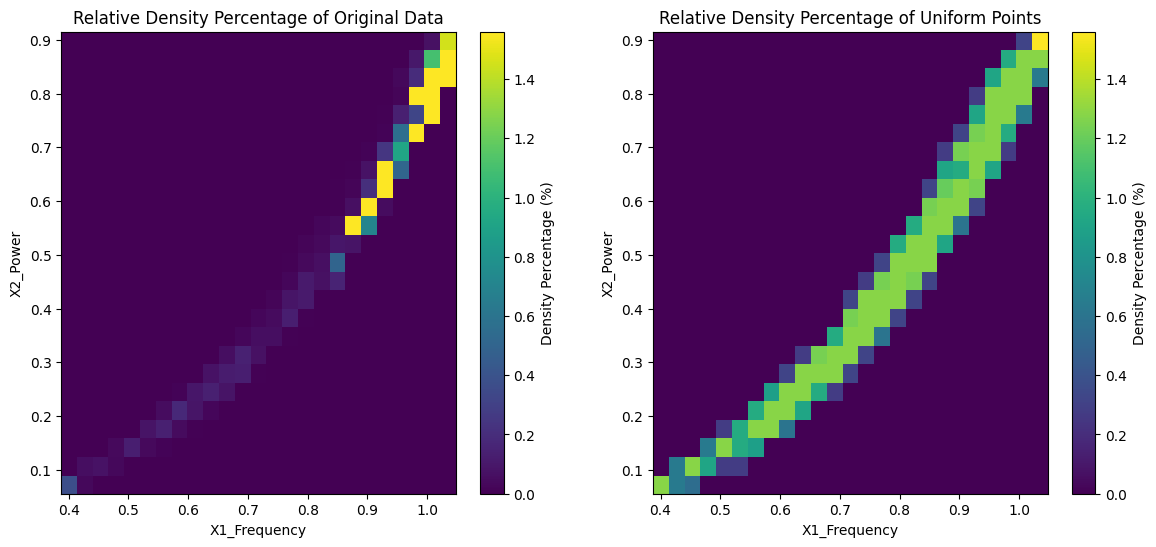

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Functions to compute the relative density for the given dataset
def compute_relative_density_percentage(data, bins=25):
    x = data['X1_Frequency']
    y = data['X2_Power']
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
    hist_percentage = hist / hist.sum() * 100  # Convert to percentage of total points
    return hist_percentage, xedges, yedges

# Step 2: Compare relative density percentages for both datasets
hist_data_percent, xedges, yedges = compute_relative_density_percentage(data)
hist_selected_percent, _, _ = compute_relative_density_percentage(uniform_data)

# Step 3: Find the maximum density percentage across both histograms
vmax = min(hist_data_percent.max(), hist_selected_percent.max())

# Step 4: Plot the relative density of the original data
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
cax1 = ax[0].imshow(hist_data_percent.T, origin='lower', aspect='auto',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis', vmin=0, vmax=vmax)
ax[0].set_title('Relative Density Percentage of Original Data')
ax[0].set_xlabel('X1_Frequency')
ax[0].set_ylabel('X2_Power')
fig.colorbar(cax1, ax=ax[0], label='Density Percentage (%)')

# Step 5: Plot the relative density of the selected points
cax2 = ax[1].imshow(hist_selected_percent.T, origin='lower', aspect='auto',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis', vmin=0, vmax=vmax)
ax[1].set_title('Relative Density Percentage of Uniform Points')
ax[1].set_xlabel('X1_Frequency')
ax[1].set_ylabel('X2_Power')
fig.colorbar(cax2, ax=ax[1], label='Density Percentage (%)')

plt.show()


In [ ]:

uniform_data = uniform_data.drop(columns=['Bin_X1', 'Bin_X2'])
uniform_data.to_csv('uniform_data.csv', index=False)

from google.colab import files
files.download('uniform_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd

def blend_datasets(selected_data, uniform_data, alpha=0.5, target_size=2500):

#Parameters:
    #- selected_data: DataFrame of the selected (original distribution-based) points.
    #- uniform_data: DataFrame of the uniform distribution points.
    #- alpha: Mixing parameter (0 = all selected, 1 = all uniform).
    #- target_size: Desired number of points in the output dataset.


    # Step 1: Ensure alpha is between 0 and 1
    alpha = np.clip(alpha, 0, 1)

    # Step 2: Calculate the number of points to draw from each dataset
    num_uniform = int(alpha * target_size)
    num_selected = target_size - num_uniform

    # Step 3: Sample points from each dataset
    blended_uniform = uniform_data.sample(n=num_uniform)
    blended_selected = selected_data.sample(n=num_selected)

    # Step 4: Concatenate the blended samples
    blended_data = pd.concat([blended_uniform, blended_selected]).reset_index(drop=True)

    return blended_data


# Step 5: Blending parameter: adjust alpha between 0 and 1
alpha = 0.2  # Adjust this value as needed to blend between the two distributions
blended_data = blend_datasets(selected_data, uniform_data, alpha=alpha, target_size=2500)

# Step 6: Display the blended data
print(f"Blended data with alpha={alpha}:")
print(blended_data.head())
blended_data.to_csv('blended_data.csv', index=False)


Blended data with alpha=0.2:
    Index  X1_Frequency  X2_Power  Bin_X1  Bin_X2
0  433709      0.522393  0.123142     NaN     NaN
1  385510      0.900404  0.647875     NaN     NaN
2  240124      0.731863  0.403230     NaN     NaN
3  405708      0.961188  0.729998     NaN     NaN
4  139394      1.020031  0.837814     NaN     NaN


## 3D Histogram Visualization and Uniformity Measurement of Blended Data


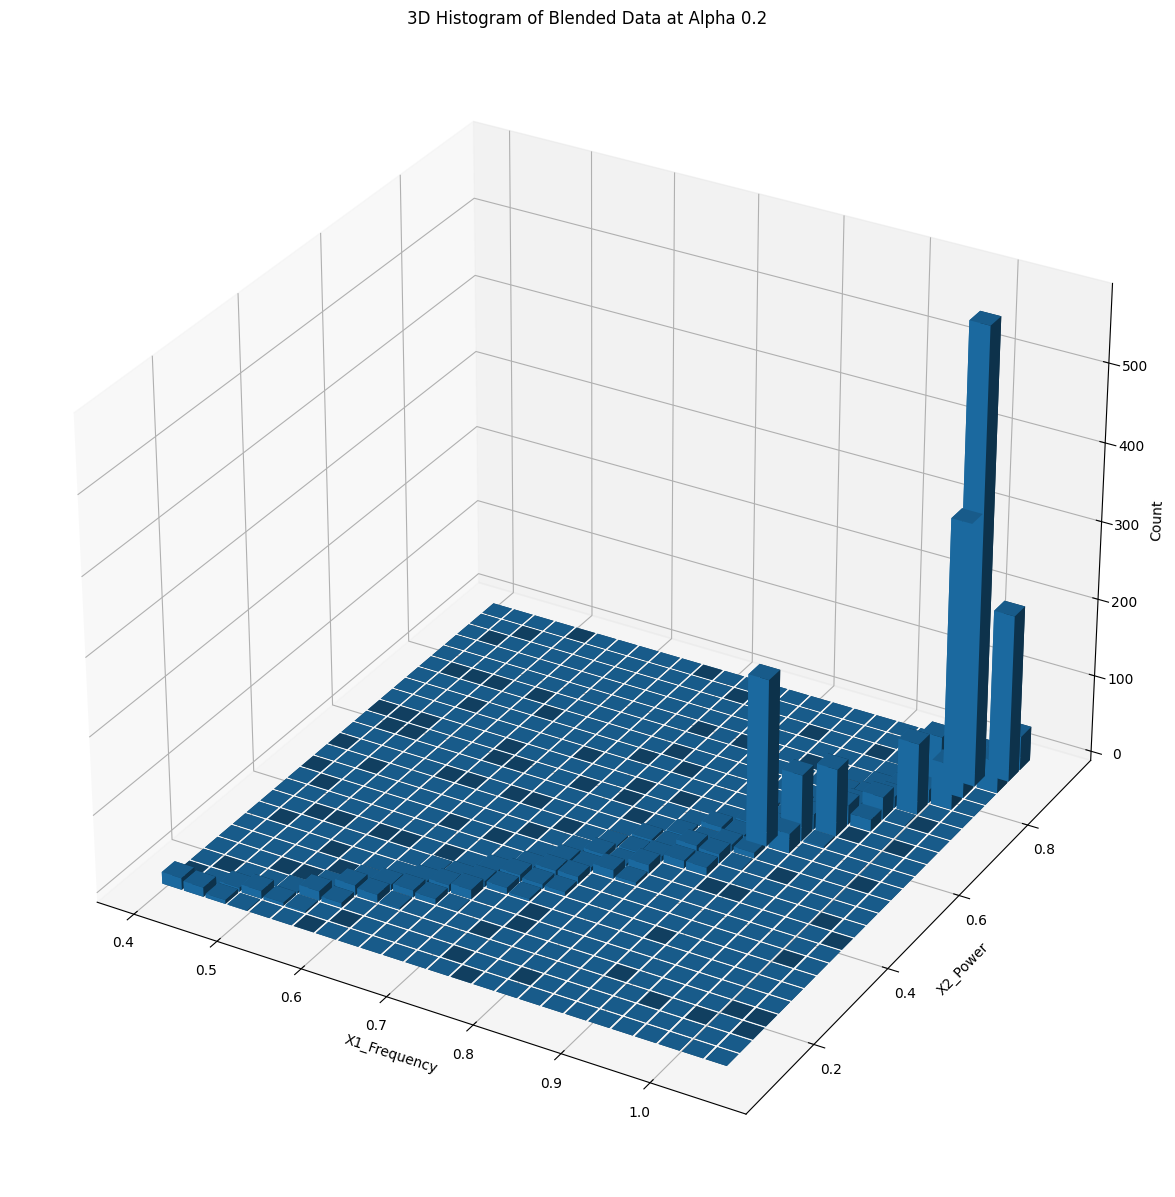

7.713481704133354

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 'uniform_data' is the DataFrame, 'X1_Frequency' and 'X2_Power' columns

# Step 1: Define the number of bins for the histogram
n_bins = 25

# Step 2: Create the 3D histogram plot
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Step 3: Calculate the 2D histogram data
hist, xedges, yedges = np.histogram2d(blended_data['X1_Frequency'], blended_data['X2_Power'], bins=n_bins)

# Step 4: Plot the 3D histogram
xpos, ypos = np.meshgrid(xedges[:-1] + 0.5 * (xedges[1:] - xedges[:-1]),
                         yedges[:-1] + 0.5 * (yedges[1:] - yedges[:-1]), indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dz = hist.ravel()


x_width = (xedges[1] - xedges[0]) * 0.9
y_width = (yedges[1] - yedges[0]) * 0.9


ax.bar3d(xpos, ypos, zpos, x_width, y_width, dz, zsort='average')

ax.set_xlabel('X1_Frequency')
ax.set_ylabel('X2_Power')
ax.set_zlabel('Count')
ax.set_title(f'3D Histogram of Blended Data at Alpha {alpha}')

plt.show()




def measure_uniformity(blended_data, n_bins=25):
 #What are we measuring?
    #Measures the uniformity of a dataset by calculating the coefficient of variation of bin counts.
    #Lower values indicate a more uniform distribution.

    # Compute the 2D histogram of the downsampled data
    hist, _, _ = np.histogram2d(blended_data['X1_Frequency'], blended_data['X2_Power'], bins=n_bins)
    hist_flat = hist.ravel()
    mean_count = np.mean(hist_flat)
    std_dev = np.std(hist_flat)
    cv = std_dev / mean_count

    return cv

measure_uniformity(blended_data, n_bins=25)

In [ ]:
import pandas as pd

# Ensure 'blended_data' only has relevant columns
blended_data = blended_data[['X1_Frequency', 'X2_Power']]

# Ensure 'data' only has relevant columns
data = data[['Index', 'X1_Frequency', 'X2_Power']]

# Merge blended_data with data to get the Index column based on matching 'X1_Frequency' and 'X2_Power'
blended_data_with_index = pd.merge(
    blended_data,
    data[['Index', 'X1_Frequency', 'X2_Power']],
    on=['X1_Frequency', 'X2_Power'],
    how='left'
)

# Display or save the result
print(blended_data_with_index)
blended_data = blended_data_with_index
blended_data_with_index.to_csv('blended_data.csv', index=False)




      X1_Frequency  X2_Power   Index
0         0.942533  0.649488  237561
1         0.644030  0.296421  171634
2         0.793281  0.509432  240156
3         0.507316  0.133941  283253
4         0.824168  0.551319  222477
...            ...       ...     ...
2495      1.024022  0.852393  231937
2496      1.024125  0.851483  215917
2497      1.009716  0.791253  446372
2498      1.013350  0.811043  369264
2499      0.975994  0.737713    2326

[2500 rows x 3 columns]


In [ ]:
# Get the list of columns
cols = blended_data.columns.tolist()

# Remove 'Index' from its current position and insert it at the front
cols.insert(0, cols.pop(cols.index('Index')))

# Reorder the DataFrame columns
blended_data = blended_data[cols]


In [ ]:
blended_data.to_csv('blended_data.csv', index=False)
# If you need to download it in Colab, use:
from google.colab import files
files.download('blended_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
blended_data


,Index,X1_Frequency,X2_Power
0,237561,0.942533,0.649488
1,171634,0.644030,0.296421
2,240156,0.793281,0.509432
3,283253,0.507316,0.133941
4,222477,0.824168,0.551319
...,...,...,...
2495,231937,1.024022,0.852393
2496,215917,1.024125,0.851483
2497,446372,1.009716,0.791253
2498,369264,1.013350,0.811043


## Visualization of Relative Density Percentage in Original and Blended Datasets

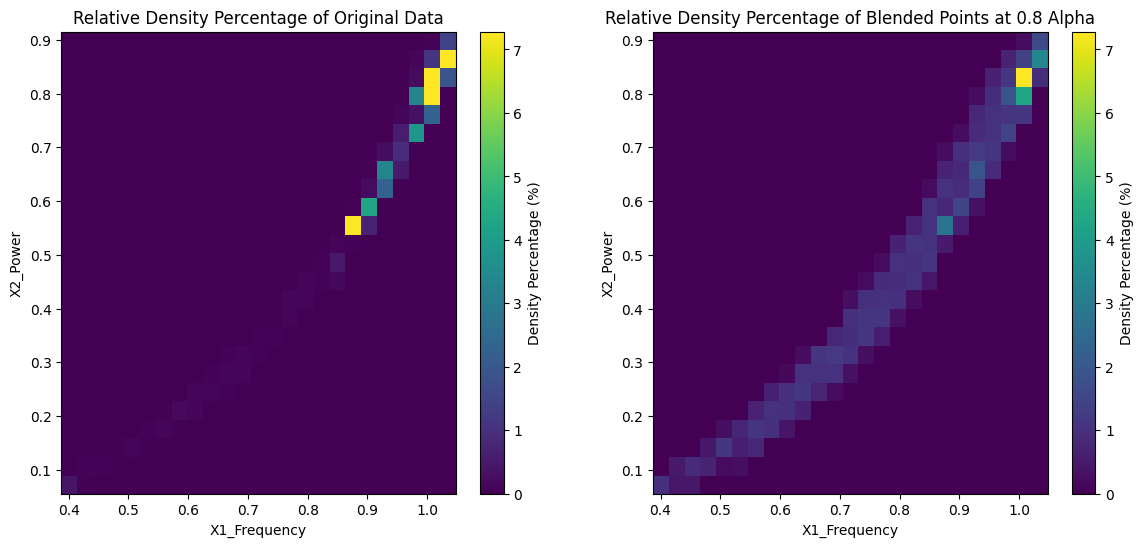

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Function to compute the relative density for given dataset
def compute_relative_density_percentage(data, bins=25):
    x = data['X1_Frequency']
    y = data['X2_Power']
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
    hist_percentage = hist / hist.sum() * 100  # Convert to percentage of total points
    return hist_percentage, xedges, yedges

# Step 2: Compare relative density percentages for both datasets
hist_data_percent, xedges, yedges = compute_relative_density_percentage(data)
hist_selected_percent, _, _ = compute_relative_density_percentage(blended_data)

# Step 3: Find the maximum density percentage across both histograms
vmax = min(hist_data_percent.max(), hist_selected_percent.max())

# Step 4: Plot the relative density of the original data
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
cax1 = ax[0].imshow(hist_data_percent.T, origin='lower', aspect='auto',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis', vmin=0, vmax=vmax)
ax[0].set_title('Relative Density Percentage of Original Data')
ax[0].set_xlabel('X1_Frequency')
ax[0].set_ylabel('X2_Power')
fig.colorbar(cax1, ax=ax[0], label='Density Percentage (%)')

# Step 5: Plot the relative density of the selected points
cax2 = ax[1].imshow(hist_selected_percent.T, origin='lower', aspect='auto',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis', vmin=0, vmax=vmax)
ax[1].set_title(f'Relative Density Percentage of Blended Points at {alpha} Alpha')
ax[1].set_xlabel('X1_Frequency')
ax[1].set_ylabel('X2_Power')
fig.colorbar(cax2, ax=ax[1], label='Density Percentage (%)')

plt.show()